1. Load Dataset

In [2]:
from datasets import list_datasets

In [3]:
all_datasets = list_datasets()
print(f"total dataset len : {len(all_datasets)}")
print(f"head : {all_datasets[:10]}")

/var/folders/nk/mmktldbn3sg0sqwfbx0ss2yc0000gn/T/ipykernel_37941/1931139622.py:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


total dataset len : 90768
head : ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
from datasets import load_dataset

emotions = load_dataset("emotion")

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
len(train_ds)

16000

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
train_ds.column_names

['text', 'label']

In [10]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [11]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [12]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

2. Dataset to DataFrame

In [13]:
import pandas as pd

In [14]:
emotions.set_format(type="pandas")
df = emotions["train"]
df

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [15]:
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [16]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [17]:
import matplotlib.pyplot as plt

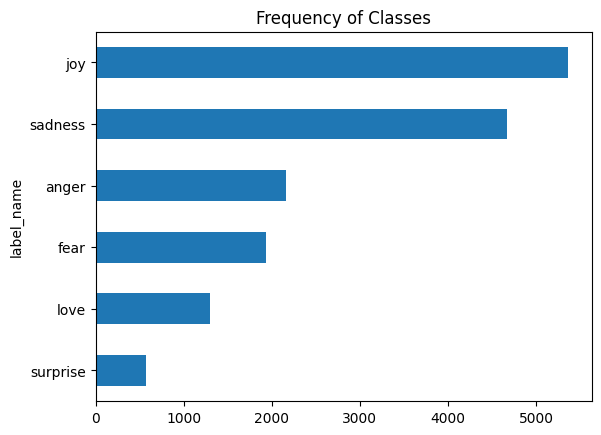

In [18]:
df["label_name"].value_counts(ascending=True).plot.barh()  # barh() : 수평 막대 그래프 / cf) bar() : 수직 막대 그래프
plt.title("Frequency of Classes")
plt.show()

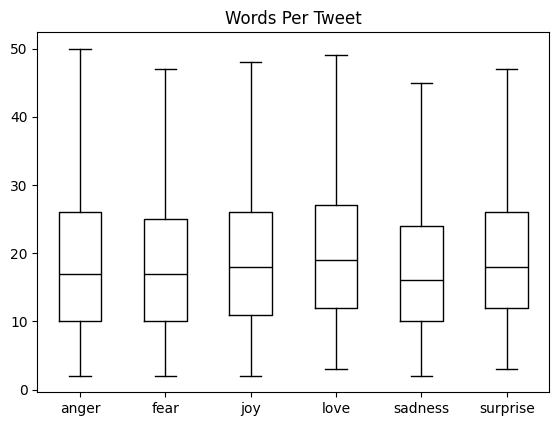

In [19]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [20]:
emotions.reset_format()

3. Visualize

In [21]:
import numpy as np
from transformers import AutoTokenizer

In [22]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)   # 자동 클래스

In [23]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [24]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)    # batch_size = 1000

In [25]:
from transformers import AutoModel, AutoTokenizer
import torch

model_ckpt = "distilbert-base-uncased"

if torch.cuda.is_available() :
    device = torch.device('cuda')
elif torch.backends.mps.is_available() :
    device = torch.device('mps')
else :
    device=torch.device('cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

In [26]:
device

device(type='mps')

In [27]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [28]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [29]:
from transformers import AutoModelForSequenceClassification

In [102]:
num_labels=6

label2id = {
    "sadness" : 0,
    "joy" : 1,
    "love" : 2,
    "anger" : 3,
    "fear" : 4,
    "surprise": 5
}
id2label = {v:k for k, v in label2id.items()}

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels, label2id=label2id, id2label=id2label).to(device)

In [103]:
from sklearn.metrics import accuracy_score, f1_score

In [104]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [105]:
from transformers import Trainer, TrainingArguments

In [106]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"models/{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",      # epoch 이 끝날 때 마다 evaluate
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  save_strategy="epoch",            # epoch 이 끝날 때 마다 model save
                                  load_best_model_at_end=True,
                                  log_level="error",
                                  use_mps_device=True               # RuntimeError: Placeholder storage has not been allocated on MPS device!
                                  )

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/transformers/training_args.py:1897: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [107]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

                                                 
 24%|██▍       | 121/500 [06:35<04:03,  1.55it/s]

{'loss': 0.831, 'learning_rate': 1e-05, 'epoch': 1.0}


































                                                 
                                              
 24%|██▍       | 121/500 [06:40<04:03,  1.55it/s]


{'eval_loss': 0.3110189139842987, 'eval_accuracy': 0.9185, 'eval_f1': 0.9175305670360311, 'eval_runtime': 4.6786, 'eval_samples_per_second': 427.478, 'eval_steps_per_second': 6.84, 'epoch': 1.0}


                                                 
 24%|██▍       | 121/500 [09:33<04:03,  1.55it/s]

{'loss': 0.2504, 'learning_rate': 0.0, 'epoch': 2.0}
































                                                 
                                              

 24%|██▍       | 121/500 [09:38<04:03,  1.55it/s]



{'eval_loss': 0.21304114162921906, 'eval_accuracy': 0.927, 'eval_f1': 0.9268434094183376, 'eval_runtime': 4.6847, 'eval_samples_per_second': 426.922, 'eval_steps_per_second': 6.831, 'epoch': 2.0}


                                                 
100%|██████████| 500/500 [05:41<00:00,  1.46it/s]

{'train_runtime': 341.795, 'train_samples_per_second': 93.623, 'train_steps_per_second': 1.463, 'train_loss': 0.5406819992065429, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5406819992065429, metrics={'train_runtime': 341.795, 'train_samples_per_second': 93.623, 'train_steps_per_second': 1.463, 'train_loss': 0.5406819992065429, 'epoch': 2.0})

In [109]:
preds_output = trainer.predict(emotions_encoded["validation"])

100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


In [110]:
preds_output.metrics

{'test_loss': 0.21304114162921906,
 'test_accuracy': 0.927,
 'test_f1': 0.9268434094183376,
 'test_runtime': 4.9771,
 'test_samples_per_second': 401.844,
 'test_steps_per_second': 6.43}

In [111]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [112]:
y_preds

array([0, 0, 2, ..., 1, 2, 1])

In [113]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [114]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map: 100%|██████████| 2000/2000 [00:05<00:00, 379.61 examples/s]


In [115]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [116]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.321060
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.065365
1950,i as representative of everything thats wrong ...,surprise,sadness,5.008366
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.980308
882,i feel badly about reneging on my commitment t...,love,sadness,4.958024
1801,i feel that he was being overshadowed by the s...,love,sadness,4.617691
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.575454
405,i have been feeling extraordinarily indecisive...,fear,joy,4.560855
1836,i got a very nasty electrical shock when i was...,fear,anger,4.547835
1683,i had applied for a job and they had assured m...,anger,joy,4.342013


In [117]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1303,i feel pathetic and uninspired,sadness,sadness,0.017838
69,i have no extra money im worried all of the ti...,sadness,sadness,0.017853
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.017925
566,i did things that i always wondered about and ...,sadness,sadness,0.017978
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.017991
1873,i feel practically virtuous this month i have ...,joy,joy,0.018002
1378,i was feeling slightly more lethargic on the f...,sadness,sadness,0.018063
571,i realize that i sound a little overdramatic w...,sadness,sadness,0.018143
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.018152
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0.018154


In [118]:
from transformers import pipeline

In [119]:
#classifier = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions")
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

In [120]:
custom_tweet = "I saw a movie today and it was really good."

In [134]:
preds = classifier(custom_tweet, )
preds[0]

/Users/parkhyerin/anaconda3/envs/venv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[{'label': 'sadness', 'score': 0.007664724253118038},
 {'label': 'joy', 'score': 0.9583908319473267},
 {'label': 'love', 'score': 0.018465956673026085},
 {'label': 'anger', 'score': 0.005483363289386034},
 {'label': 'fear', 'score': 0.0031946662347763777},
 {'label': 'surprise', 'score': 0.006800442934036255}]

In [131]:
preds_df = pd.DataFrame(preds[0])

preds_df

,label,score
0,sadness,0.007665
1,joy,0.958391
2,love,0.018466
3,anger,0.005483
4,fear,0.003195
5,surprise,0.006800


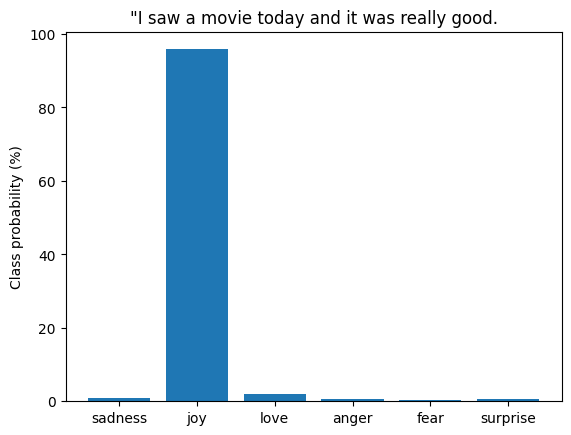

In [132]:
labels = emotions["train"].features["label"].names

plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}')
plt.ylabel("Class probability (%)")
plt.show()